In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import decision_trees_helper as dthelp
%aimport decision_trees_helper

th = dthelp.TitanicHelper()

import class_helper
%aimport class_helper

import os 

from IPython.display import Image


# Plan

In this lecture we review several Classical Machine Learning models.

These also allow us to introduce some concepts that are useful for many other models.

- Decision Trees
    - Simple Trees
    - Random Forests
        - introduce 
            - Ensembles
            - Bootstrapping, Bagging
- Boosting
- Support Vector Machines
    - Margin Loss

# Decision Tree Terminology

In contrast to other models (e.g., Logistic Regression), which had some mathematical basis,
Decision Trees will feel very operational.

Let's dive in with an example: a Decision Tree to solve the Titanic Survival Classification task.

As usual we let $C$ denote the set of distinct categories/classes (possible targets) for our Classification task.

In [4]:

ret = th.make_titanic_png(max_depth=3)
fig = ret["plt"]["fig"]
plt.close(fig)

if hasattr(ret, "fname"):
    Image(filename=ret["fname"] + ".png") 

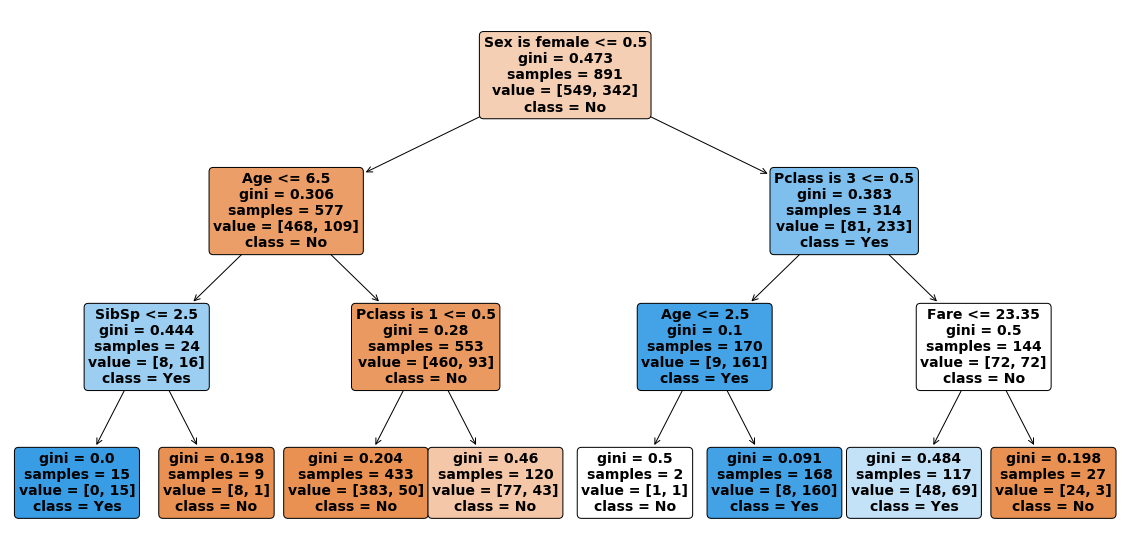

In [5]:
fig

## Nodes

- Each box is called a *node*
- There are two types of nodes
    - Those with no arrows exiting (called a *leaf* or *terminal* node)
    - Those with arrows exiting (called an *interior* or *non-terminal* node)
- The single node with no arrow entering is called the *root* node

## Edges

- An arrow, which is directed, is called an *edge*
    - The node from which an edge exits is called a *parent* node
    - The node to which an edge is directed is called a *child* node

Edges connect only a parent to a child.

The edges thus define an *acyclic* graph

## Labels

A non-leaf node is labeled with a True/False question/test that is applied to an example
- The test is evaluated on an example
- The left child of the node is associated with a True evaluation of the test
- The right child of the node is associated with a False evaluation of the test

A leaf node is labeled with one category/class in $C$

Consider the $n$-dimensional space of feature vectors $\x$
$$\text{domain}(\x) = \text{domain}(\x_1) \times \text{domain}(\x_2) \times \ldots  \times \,\text{domain}(\x_n)$$ 

With each possible feature vector $\x$ in the space, we can associate a target $f(\x)$.

We will take the liberty to have $S$ denote the infinite set of *all possible examples*
$$S = \{ (\x, \y) \, | \, \x \in \text{domain}(\x), \y = f(\x) \}$$



- There is a subset of $S$ associated with each node: $S_\node{n}$
- The test at node $\node{n}$ partitions $S_\node{n}$ into disjoint subsets $L_\node{n}, R_\node{n}$

$$
\begin{array}[llll]\\
S_\node{n} & = & L_\node{n} \cup R_\node{n} \\
 \phi& = & L_\node{n}  \cap R_\node{n} \\
 L_\node{n} & = & \{ (\x^\ip, \y^\ip) | (\x^\ip, y^\ip) \in S_\node{n}, \; \text{"True" answer to question} \} \\
 R_\node{n} & = & \{ (\x^\ip, \y^\ip) | (\x^\ip, y^\ip) \in S_\node{n}, \; \text{"False" answer to question} \} \\
\end{array}
$$

That is, the question  partitions $S_\node{n}$ into  "left" and right subsets $L_\node{n}, R_\node{n}$ depending on the answer.

## Example: Decision Tree for Titanic Survival

Let's illustrate using a Decision Tree for the Titanic Survival Classification task.
- High level
- We will subsequently explain the exact details for the labels and colors

**WARNING: The labels on the trees ARE confusing for binary, categorical features**
- Artifact of the program that constructs the tree
- Consider the label:
    - `Sex is Female <= 0.5`
    - This is an awkward way of saying
        - `Is Female` == 0, since `Is Female` $\in \{ 0, 1 \}$
        - `Is not Female`
        - `Is Male`

So look at the label `Sex is Female <= 0.5` as being equivalent to the complement: `Sex is NOT Female`

In [6]:
th = dthelp.TitanicHelper()

ret = th.make_titanic_png(max_depth=2, node_ids=True)
if hasattr(ret, "fname"):
    Image(filename=ret["fname"] + ".png")  

fig_titanic2 = ret["plt"]["fig"]
plt.close(fig_titanic2)

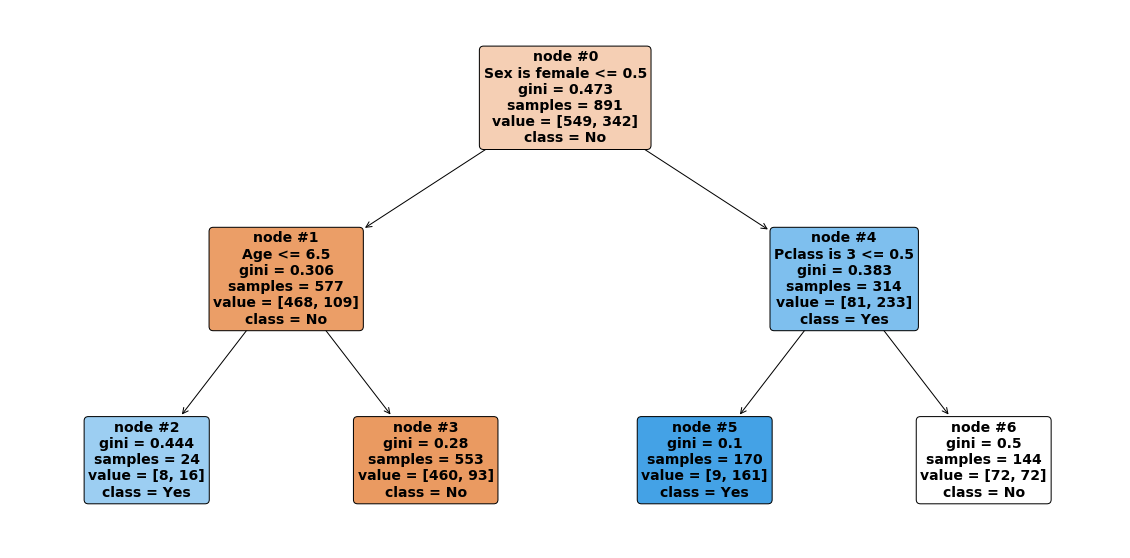

In [7]:
fig_titanic2

- Root node $#0$
    - $S_{\#0} = S$ is the entire universe of examples
    - Labeled with question: "Is $\x$ *non* Female ?"
    
- Left child $#1$
    - $S_{\#1} = $ subset of $S_{\#0}$ that are `Male'

- Right child $#4$
    - $S_{\#4}  = $ subset of $S_{\#0}$ that are `Female'



- Left child $#2$
    - $S_{\#2} $ subset of $S_{\#1} $ with `Age` $\le 6.5$
    - Is a *leaf*
    - Labeled with class `Yes` (i.e., Survive)   
        - Corresponding to the subset of entire universe $S$ that are Males aged no more than 6.5 years
    
- Right child $#3$
    - $S_{\#3}  $ subset of $S_{\#1} $ with `Age` $\gt 6.5$
    - Is a *leaf*
    - Labeled with class `No` (i.e., did not Survive)

## Prediction

Given a test example (with features $\x$)
- Apply the sequence of questions to $\x$
    - Evaluate the test of the current node on $\x$
    - Depending on the evaluation
    - Evaluate the test of the Left/Right child of the current node

- This defines a path to a leaf node
- Prediction $\hat{\y}$ is the class label of the leaf

This makes prediction in Decision Trees very fast.
    

<img src="images/Back_to_parent.jpg">

# Training: a first look at the algorithm

## Feature encoding

Before describing the algorithm, we enumerate the features we will use
- Numeric: Age, SibSp, Parch, Fare
- Categorical: Sex, Pclass

The categorical features will be One Hot Encoded
- The Sex feature is replaced by two binary features: $\text{Is}_\text{Female}, \text{Is}_\text{Male}$
- The Pclass feature is replaced by three binary indicator features 
$\text{Is}_\text{Class 1}, \text{Is}_\text{Class 2}, \text{Is}_\text{Class 3}$

So don't expect to see a test like `Sex == Male` ?
- Instead: "`Is Male == 1 ?`"
- Testing  "$\text{Is}_\text{Male} == \text{True}$  ?"

**WARNING: The labels on the trees ARE confusing for binary, categorical features**
- Artifact of the program that constructs the tree
- Consider the label:
    - `Sex is Female <= 0.5`
    - This is an awkward way of saying
        - `Is Female` == 0, since `Is Female` $\in \{ 0, 1 \}$
        - `Is not Female`
        - `Is Male`
        
        
So look at the label `Sex is Female <= 0.5` as being equivalent to the complement: `Sex is NOT Female`

## The training algorithm

We use the training examples as a proxy for $S$, the universe of examples
$$ S_\text{train} = \langle \X, \y \rangle= [ \x^\ip, \y^\ip | 1 \le i \le m ]$$

to build the tree *recursively*.

Let's start with the root node
- Let $\node{n}_\text{root}$ denote the root node
- Associate the entire set of training examples $S_\text{train}$ with $S_\node{root} = S_\text{train}$

We construct a node $\node{n}$ by the procedure `Construct(`$\node{n}$ `)`:
- Use $S_\node{n}$ to label $\node{n}$ with a test/question
- The test splits $S_\node{n}$ into
    - $L_\node{n}$: the subset of $S_\node{n}$ consisting of examples where the test is True
    - $R_\node{n}$: the subset of $S_\node{n}$ consisting of examples where the test is False
- if $L_\node{n}$ is not empty: 
    - create a new node $\node{n}_L$ as the left child or $\node{n}$
    - `Construct(`$\node{n}_L$ `)`
- if $R_\node{n}$ is not empty: 
    - create a new node $\node{n}_R$ as the right child of $\node{n}$
    - `Construct(`$\node{n}_R$ `)`

To illustrate, let's apply `Construct(`$\node{n}_\text{root}$ `)`:

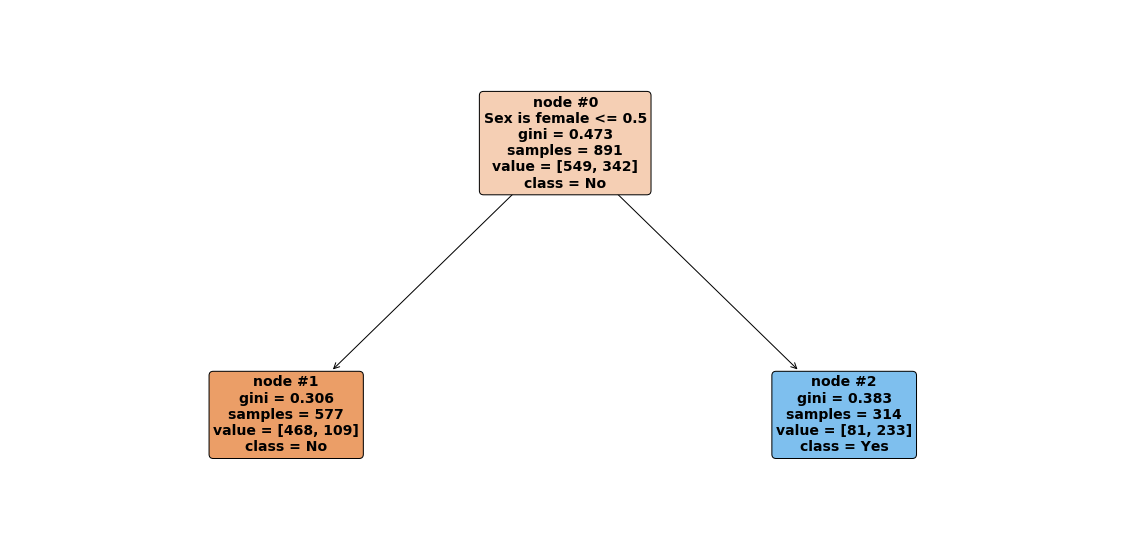

In [8]:
th = dthelp.TitanicHelper()

ret = th.make_titanic_png(max_depth=1, node_ids=True) 


We will describe the notation for each node.

- Root node: $\#0$
    - Labeled with question: "Is $\x$ *non* Female ?"
    - $S_{\#0}$ is the entire training set
        - `samples = 891`: This is number of examples in the training set
        - `values = [549, 342]`: The examples of $S_{\#0}$ can be divided into 
            - 549 with `Survived` == No
            - 342 with `Survived` ==Yes 
    

- Left child of root: $\#1$
    - `samples = 577`: This is the subset of $S_{\#0}$ (training set) consisting of the 577 non-`Female` (i.e.,`Male`) examples
    - `values = [468, 109]`
    - The examples of $S_{\#1}$  can be divided into
        - 468 with `Survived` == No
        - 109 with `Survived` == Yes
    
- Right child of root $\#2$:
    - `samples = 314`: This is the subset of $S_{\#0}$ (training set) consisting of the 314 `Female` examples
    - `values = [81, 233]`
    - The examples of $S_{\#2}$  can be divided  into
        - 81 with `Survived` == No
        - 233 with `Survived` == Yes

At this point, the left and right children are both leaf nodes
- Left child of root: $\#1$
    - Labeled with prediction "No": `class = No`
- Right child of root: $\#2$
    - Labeled with prediction "Yes": `class = Yes`

"No" is colored orange
"Yes" is colored blue

We can now recursively apply `Construct(`$\#1$ `)` and `Consruct(`$\#2$ `)`
- Note that the numbering of the nodes changes

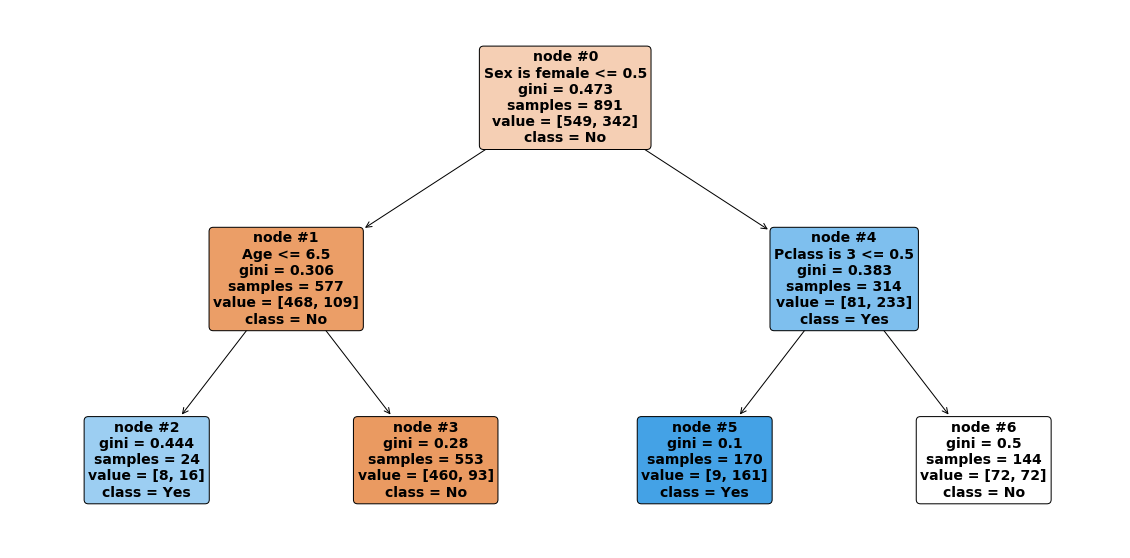

In [9]:
th = dthelp.TitanicHelper()

ret = th.make_titanic_png(max_depth=2, node_ids=True)


With the tree now depth 2, we have 4 leaf nodes.

If we were to continue this procedure indefinitely
- We would eventually have "pure" leaf nodes
    - All examples in the node are in the same class
    - Further splitting would not change the predicted class
    - The algorithm would stop

<img src="images/Back_to_parent.jpg">

# Training: a deeper look at the algorithm

## Encoding the test

The test evaluated at node $\node{n}$ is a comparison
- Of a feature $\x_j$
- With a threshold value $t_{\node{n},j}$

Thus we can represent the test at $\node{n}$ as the pairs $(\x_j, t_{\node{n},j})$.

Deciding the $j$ and $t_{n,j}$ at a node $\node{n}$ will be at the heart of the algorithm.

### The threshold

Consider feature $\x_j$.

We restrict the possible threshold values $V_j$ for comparison with $\x_j$ to
- The distinct values of $\x_j$ in the training set
$$
V_j = \{ \x_j^\ip | 1 \le i \le m \}
$$

This is true for both numeric and categorical features $\x_j$.

**Note**
- A variant uses the *mid-point* between distinct values
- The labeling of questions in our diagram always uses the comparison
$$
\x_j \le \text{midpoint value}
$$
- So categorical tests look like
$$
\text{Is Female} \le 0.5
$$
which is equivalent to
$$
\text{Is Female} == 0
$$

## Choosing the test

There are
- A finite number ($n$) of features
- A finite number $|| V_j ||$ of distinct values for the threshold

So there are only a countable set of possible choices for the test.

How do we choose the test $(\x_j, t_{\node{n},j})$ with which to label a non-leaf node ?



[sklearn manual](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)

We will describe the algorithm for choosing the test.

Let's re-write our initial algorithm to give us a little more flexibility:

Initialization:
- Let $\node{n}_\text{root}$ denote the root node
- Associate the entire set of training examples $S_\text{train}$ with $S_\node{root} = S_\text{train}$

Here is pseudo-code for a procedure `split(`$\node{n}, S_\node{n}$ `)`to construct a sub-tree rooted at node $\node{n}$:
- if we *can split*  $S_\node{n}$
   - Determine the question that "best" splits $S_\node{n}$ into $L_\node{n}, R_\node{n}$
   - Create a child node $\node{n}_L$ with corresponding examples $L_\node{n}$
   - Create a child node $\node{n}_R$ with corresponding examples $R_\node{n}$
   - `split`$(\node{n}_L, L_\node{n})$
   - `split`$(\node{n}_R, R_\node{n})$
   

This pseudo-code was vague on
- How do we define the "best" split of the examples at node $\node{n}$ ?
- What does "if we can split"a node mean ?

We answer each in turn.

### Measuring the quality of a split

In order to determine the "best" split, we need a metric of the quality of the split.

We start with measuring the "randomness" of a node $\node{n}$
- The examples $S_\node{n}$ may correspond to different classes, each with
its own frequency.

- So $S_\node{n}$ induces a probability distribution on the class labels.

- We need a metric that measures the randomness of this distribution at node $\node{n}$

If we had a metric of randomness, we can define
our quality metric of a split as the difference between
- The randomness of $S_\node{n}$
- The weighted (by size) randomness of nodes $L_\node{n}, R_\node{n}$

We call this metric the *information gain* achieved by the split.

The *best split* would be the one which maximizes the information gain.

Any ideas for a metric of randomness of a distribution ?

Entropy !

This a a very good measure to use.

In the interest of showing alternatives,
we continue with a different choice.

Gini.


### Gini score

For node $\node{n}$:
- Let $p_{\node{n},c}$ be the fraction of $S_\node{n}$ examples with class $c \in C$
$$
p_{\node{n},c} = \frac{\cnt{\node{n},c}}{|S_\node{n}|}
$$
    
Then the Gini score (metric of randomness) of node $\node{n}$ is defined as
$$
G_\node{n} = 1 - \sum\limits_{c \in C} {{p_{\node{n},c}}^2}
$$

$G_\node{n}$ is called the **impurity** of node $\node{n}$

**Note** 

We will try to minimize *impurity* (just as we would minimize entropy)

Goal is to have pure nodes, i.e., all examples in node $\node{n}$ are in same target class.

Here's what Gini looks like as a function of $p_{\node{n},c}$ for binary $C$

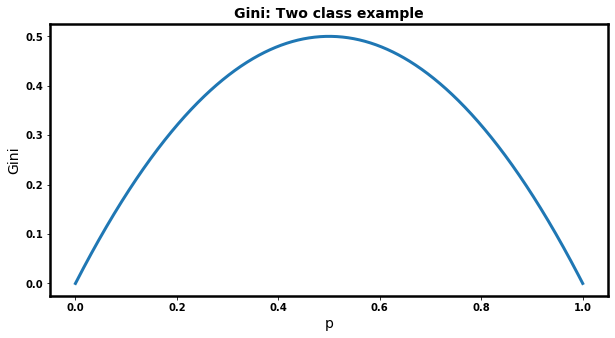

In [10]:
gh = dthelp.GiniHelper()
_ =gh.plot_Gini()

Just like Entropy, Gini impurity
- Is minimized by a pure distribution (of either class)
- Is maximized by an equally balanced distribution

#### Gini illustration

It will be easiest to illustrate with a toy example having only categorical features.

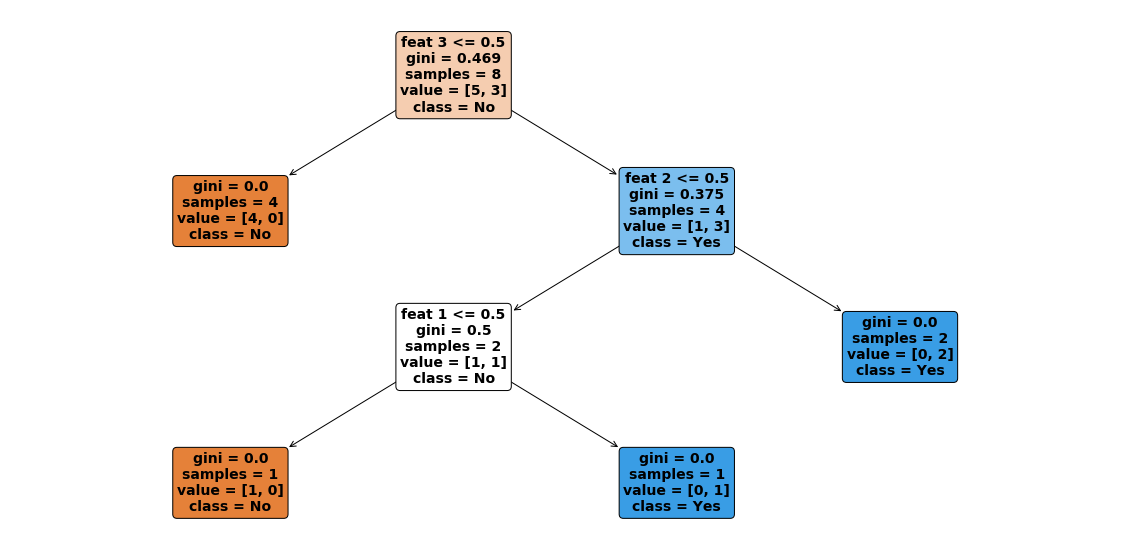

In [11]:
gh = dthelp.GiniHelper()
_ = gh.make_logicTree_png()

Here are the examples

In [12]:
df_lt = gh.df_lt
df_lt

,feat 1,feat 2,feat 3,target
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,1,1,1
4,1,0,0,0
5,1,0,1,1
6,1,1,0,0
7,1,1,1,1


![](images/logic_tree.png)

Let's compute Gini of the root

In [13]:
gini_lt = gh.gini(df_lt, gh.target_name_lt, gh.feature_names_lt, noisy=True)

print("\n\nMethod returns ", gini_lt)

Gini, by hand:
Count by target:
	
0    5
1    3
Name: target, dtype: int64
Frequency by target:
	
0    0.625
1    0.375
Name: target, dtype: float64

1 - sum(freq**2) = 0.469


Method returns  0.46875


And Gini of the right sub-tree

In [14]:
df_right = df_lt[ df_lt["feat 3"] > 0.5 ]

gh.gini( df_right, gh.target_name_lt, gh.feature_names_lt, noisy=True)

Gini, by hand:
Count by target:
	
1    3
0    1
Name: target, dtype: int64
Frequency by target:
	
1    0.75
0    0.25
Name: target, dtype: float64

1 - sum(freq**2) = 0.375


0.375

#### The "best" $(j,k)$ split: From Gini of children, to Cost for split at parent

Let node $\node{n}$ 
- Have child nodes $\node{n}_L, \node{n}_R$
- $S_\node{n}$ denote the set of examples corresponding to node $\node{n}$
- Have Gini impurity score $G_\node{n}$

We can associate a Cost with the choice of splitting node $\node{n}$ with question $(j, t_{\node{n},j}$):
$$
\text{Cost}_{j,t_{\node{n},j}}(S_\node{n}) = \frac{m_L}{(m_L + m_R)} G_L + \frac{m_R}{(n_L + m_R)} G_R
$$

- where $m_L =| L_\node{n} |, m_R = | R_\node{n}|$

That is, the Cost of splitting $S_\node{n}$ on $X_j \le t_{\node{n},j}$ is 
- The weighted sum of the Gini's of the partitions created.

Finally:
- The best split $(j, t_{\node{n},j})$ for node $\node{n}$ is the one that minimizes the Cost

$$ j, t_{\node{n},j} = \argmin{j,t_{\node{n},j}} { \text{Cost}_{j,t_{\node{n},j}} }$$
- $1 \le j \le n$
- $t_{\node{n},j} \in V_j$

This is the split that maximizes Information Gain (since $G_\node{n}$ is constant, relative to the choices)

Let's examine the cost of split at the root for each (binary) feature

In [15]:
gh.cost(df_lt, gh.target_name_lt, gh.feature_names_lt, noisy=True)

Split feature feat 1 on 0.00
	G_left (# = 4) = 0.375, G_right (# = 4) = 0.500
	weighted (G_left, G_right) = 0.438
Split feature feat 2 on 0.00
	G_left (# = 4) = 0.375, G_right (# = 4) = 0.500
	weighted (G_left, G_right) = 0.438
Split feature feat 3 on 0.00
	G_left (# = 4) = 0.000, G_right (# = 4) = 0.375
	weighted (G_left, G_right) = 0.188


0.1875

So split on $(3, 0)$ (feature "feat 3", threshold 0) gives the minimum cost.

That explains the split at the root.

### What does "if we can split"a node mean

Time to answer our second vague statement: is there a time when we can't/shouldn't split node $\node{n}$

**When can't we split** $S_\node{n}$ **?**
- $| S_\node{n} | = 0$
    - an empty child, which we ignore (n.b., whose sibling is pure)
- $S_\node{n}$ is pure

**When shouldn't we split** $S_\node{n}$ **?**

One obvious case
- When the Information Gain of **all** possible splits is negative

There are some less obvious cases related to the Performance Measure of our out of sample test set.

If we don't restrict the answer to "if we can split" 
- Then we will eventually have
leaf nodes that are all pure.
- That's good, but it's also possible to have a single example corresponding to a leaf node
- Overfitting !
    - Memorize training: each leaf memorizes an example


## Prediction $\hat{\y}_\node{n}$ for node $\node{n}$

We need to label a *leaf* node $\node{n}$ with a category $c \in C$.

This will be the prediction $\hat{\y}^\ip$ that will be made for test example $\x^\ip$.

We do this by choosing
- The class $c$ 
- That occurs most frequently in $S_\node{n}$, the set of training examples associated with node $\node{n}$
$$
\begin{array}[lll]\\
\cnt{\node{n},c} = | \{ \, i \, | \, (\x^\ip, \y^\ip) \in S_\node{n}, \y^\ip = c \,\} | \\
\hat{\y}_\node{n} = \argmax{c \in C}{ \cnt{\node{n},c} }
\end{array}
$$

**Note**

Our diagrams use the same logic for labeling non-leaf nodes with a class.

<img src="images/Back_to_parent.jpg">

## Decision Tree Regression

A Classifier (like the Decision Tree) that partitions examples can be modified
to solve a Regression task.

We simply need to modify
- The category label assigned to a leaf node
- The measure used for the quality of a split

A category label is associated with each leaf node $\node{n}$
- Classification: label is target category occurring with highest frequency in the examples in $S_\node{n}$
$$
\hat{\y}_\node{n} = \argmax{c \in C}{ \cnt{\node{n},c} }
$$
- Regression: label is *average* of the targets of the examples in $S_\node{n}$
$$
\hat{\y}_\node{n} = \dfrac{1}{| S_\node{n} |}\sum\limits_{\scriptstyle (\x^\ip, \y^\ip) \in S_\node{n}} \y^{(i)}
$$
-

The quality of the split of $S_\node{n}$ into $L_\node{n}$ (size $m_L$) and $R_\node{n}$ (size $m_R$)
- Classification: minimize weighted impurity (or entropy) of the subsets created by split
$$
\begin{array}[lll]\\
\text{Cost}_{j,t_{\node{n},j}}(S_\node{n}) & = & \frac{m_L}{(m_L + m_R)} G_L + \frac{m_R}{(n_L + m_R)} G_R \\
\text{where } \\
G_s & = & \text{impurity/entropy of set s}, s \in {L,R}\\
\end{array}
$$

- Regression: minimize the MSE of the subsets created by split
$$
\begin{array}[lll]\\
\text{Cost}_{j, t_{\node{n},j}}(S_\node{n}) & = & \dfrac{m_L}{(m_L + m_R)}\text{MSE}_L + \dfrac{m_R}{(m_L + m_R)}\text{MSE}_R
\\
\text{where } \\
\text{MSE}_s & = & \text{MSE of set s}, s \in {L,R}\\
             & = & \frac{1}{|s|} \sum_{(\x^\ip, y^\ip) \in s} { (\hat{\y}_s - \y^\ip)^2 }& \text{where } \hat{\y}_s \text{ is the predicted value for all examples in set } s \\
\end{array}
$$


<img src="images/Back_to_parent.jpg">

# Overfitting example

Here is a Regression task that illustrates the tendency of "deep" trees to overfit.

The light blue line is the "line of best fit".

In [16]:
rh = dthelp.RegressionHelper()

ret =rh.make_plot()
overfit_fig, trees_fig = ret["fig1"], ret["fig2"]

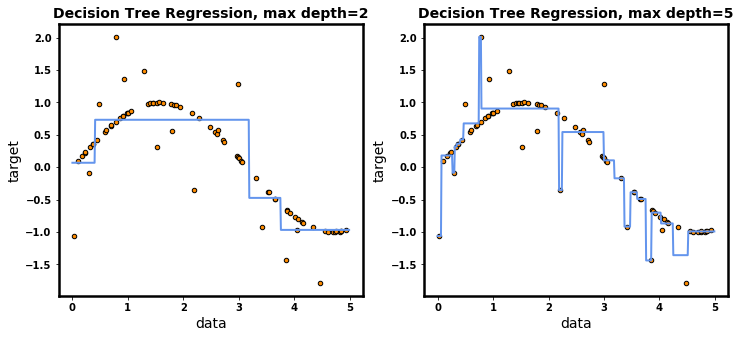

In [17]:
overfit_fig

Consider the blue line of the left figure, produced by a Decision Tree of depth 2:

$$
\hat{\y}^\ip = 
\left\{
    {
    \begin{array}{lll}
     0 & \textrm{if } &          & \x^\ip &       \le 0.408  \\
     1  & \textrm{if }&  0.408 < & \x^\ip & \le 3.186 \\
     -0.472  & \textrm{if } & 3.186 <  &\x^\ip & \le 3.758 \\
     \vdots
    \end{array}\\
    }
\right.
$$

corresponding to the Decision Tree:

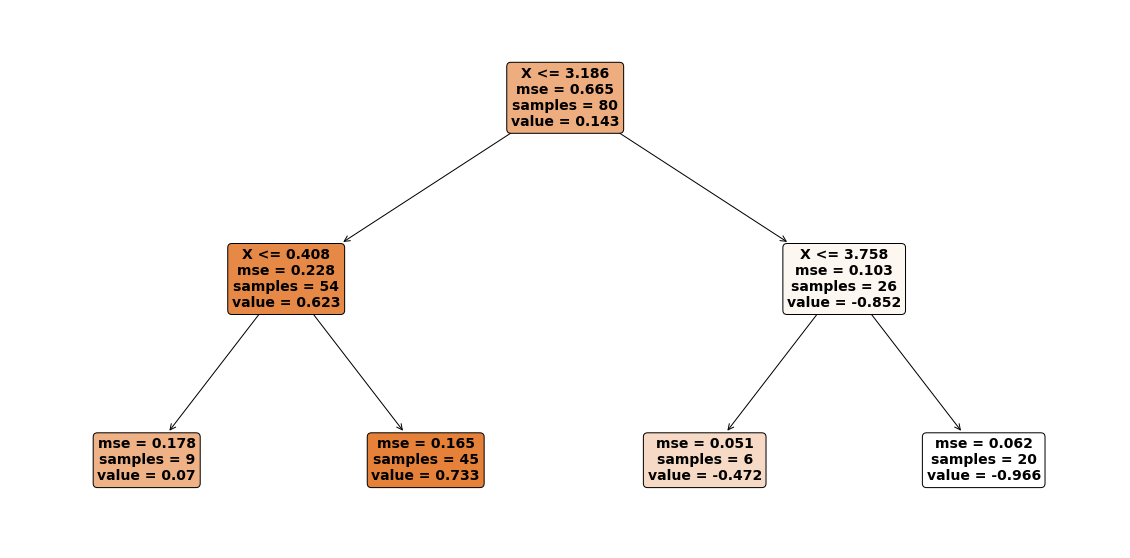

In [18]:
trees_fig[0]

The deeper Decision Tree (right figure) results in a very complex "line"
- It's fit has less error
- But may be highly over fit

An overfit model may  more closely match the *training* examples
- But fail to generalize (out of sample) as well as a simpler model


<img src="images/Back_to_parent.jpg">

## Hyper parameters for Decision Trees
### Hyper parameters to control overfitting
You can combat overfitting with several parameters
- `max_depth`: maximum depth of tree
- `min_samples`: minimum size (no. of observations) to split a node
- `min_samples_leaf`: minimum number of samples for a leaf

### Other hyper parameters

Recall that our threshold $t_{\node{n},j}$ for feature $\x_j$ was drawn from $V_j$
- Set of distinct values of $\x_j$ in the training set

This can be quite large.  Perhaps defining a smaller number of thresholds may work even better.
- The choice of thresholds is a hyper parameter

<img src="images/Back_to_parent.jpg">

In [19]:
print("Done")

Done
